In [6]:
# Imports

import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

**Access stored BTC and ETH dataframe**

In [7]:
%store -r btc_df
%store -r eth_df

In [8]:
# Ensure that BTC dataframe is imported properly
btc_df.head()

,Open,value
Date,,
2018-02-01,10237.299805,30
2018-02-02,9142.280273,15
2018-02-03,8852.120117,40
2018-02-04,9175.700195,24
2018-02-05,8270.540039,11


In [9]:
# Ensure that ETH dataframe is imported properly
eth_df.head()

,Open,value
Date,,
2018-02-01,1119.369995,30
2018-02-02,1035.770020,15
2018-02-03,919.210999,40
2018-02-04,964.666992,24
2018-02-05,834.958008,11


## Create functions for SMA and returns

In [32]:
def create_actual_return(signals_df):
    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["Open"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()

    # Review the DataFrame
    # display(signals_df.head())
    
    return signals_df

In [39]:
def generate_sma(signals_df, SMA_Fast, SMA_Slow):
    # Generate the fast and slow simple moving averages
    signals_df['SMA_Fast'] = signals_df['Open'].rolling(window=SMA_Fast).mean()
    signals_df['SMA_Slow'] = signals_df['Open'].rolling(window=SMA_Slow).mean()

    signals_df = signals_df.dropna()

    # Review the DataFrame
    # display(signals_df.head())
    
    return signals_df

In [40]:
def generate_signal(signals_df):
    # Initialize the new Signal column
    signals_df['Signal'] = 0.0

    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

    signals_df = signals_df.dropna()
    
    # Review the DataFrame
    # display(signals_df.head())

    return signals_df
        

In [48]:
def generate_strategy_return(signals_df):
    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()
    
    return signals_df

In [49]:
def plot_strategy_return(signals_df):
    # Plot Strategy Returns to examine performance
        (1 + signals_df['Strategy Returns']).cumprod().plot()

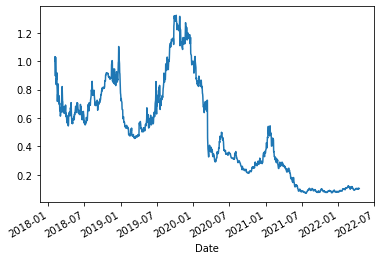

In [51]:
plot_strategy_return(btc_df)

In [53]:
def run_sma_and_return_functions(signals_df, SMA_Fast, SMA_Slow):
    create_actual_return(signals_df)
    generate_sma(signals_df, SMA_Fast, SMA_Slow)
    generate_signal(signals_df)
    generate_strategy_return(signals_df)
    
    return signals_df
    
    
    

In [56]:
btc_test_1 = run_sma_and_return_functions(btc_df, 4, 100)
btc_test_1.tail()

,Open,value,SMA_Fast,SMA_Slow,Signal,Actual Returns,Strategy Returns
Date,,,,,,,
2022-04-11,42201.039062,32,42692.335938,41615.028164,-1.0,-0.013559,-0.013559
2022-04-12,39533.714844,20,41699.480469,41533.556055,-1.0,-0.063205,0.063205
2022-04-13,40123.570312,25,41159.853516,41461.356328,1.0,0.014920,-0.014920
2022-04-14,41160.218750,28,40754.635742,41408.370000,1.0,0.025836,0.025836
2022-04-16,40547.324219,28,40341.207031,41354.849648,-1.0,-0.014890,-0.014890


In [57]:
eth_test_1 = run_sma_and_return_functions(eth_df, 4, 100)
eth_test_1.tail()

,Open,value,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,,
2022-04-11,3209.576904,32,-0.015857,3224.029236,2975.870830,-1.0,-0.015857
2022-04-12,2981.420654,20,-0.071086,3161.066284,2967.992053,-1.0,0.071086
2022-04-13,3029.877930,25,0.016253,3120.541748,2959.995476,1.0,-0.016253
2022-04-14,3117.821777,28,0.029026,3084.674316,2953.560078,1.0,0.029026
2022-04-16,3040.301025,28,-0.024864,3042.355347,2946.020398,-1.0,-0.024864


## Test and train the data

In [72]:
def fetch_data_for_training(signals_df, months):
    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()
    
    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']
    
    # Select the start of the training period
    training_begin = X.index.min()
    
    # Select the ending period for the training data with an offset of x months
    training_end = X.index.min() + DateOffset(months)

    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(days=1):]
    y_test = y.loc[training_end+DateOffset(days=1):]
    
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    return X_test, y_test, X_train_scaled, X_test_scaled

In [73]:
fetch_data_for_training(btc_df,3)

(                SMA_Fast      SMA_Slow
 Date                                  
 2018-05-19   8417.870117   8888.885537
 2018-05-20   8305.505127   8888.737441
 2018-05-21   8241.150146   8900.689844
 2018-05-22   8279.220215   8908.358242
 2018-05-23   8361.230225   8916.178345
 ...                  ...           ...
 2022-04-11  42943.951172  41656.135234
 2022-04-12  42692.335938  41615.028164
 2022-04-13  41699.480469  41533.556055
 2022-04-14  41159.853516  41461.356328
 2022-04-16  40754.635742  41408.370000
 
 [1428 rows x 2 columns],
 Date
 2018-05-19    1.0
 2018-05-20   -1.0
 2018-05-21    1.0
 2018-05-22   -1.0
 2018-05-23   -1.0
              ... 
 2022-04-11   -1.0
 2022-04-12   -1.0
 2022-04-13    1.0
 2022-04-14    1.0
 2022-04-16   -1.0
 Name: Signal, Length: 1428, dtype: float64,
 array([[ 1.64174838,  1.58937552],
        [-0.5070846 ,  0.05645516],
        [-0.11800099, -0.5817526 ],
        [-1.01666279, -1.06407809]]),
 array([[-4.85542479e+00, -2.14852193e+00],
  